In [112]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [113]:
data = pd.read_csv('/kaggle/input/filtered-and-translated-nlp/filr.csv')

In [114]:
X = data['Translated']
y = data['Label']

In [115]:
X

0      After hacking state TV by replacing propaganda...
1      #flowers #lovers\nMake love not war.\nMarc Cha...
2      If only we all showed more love and understand...
3      Who are the soldiers we see in the videos? Are...
4      I didn't think #Salvini could make his positio...
                             ...                        
475    If I write that Ms. #Zelensky was allegedly sp...
476    #Zelensky and his wife #OlenaZelenska bought a...
477    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
478    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
479    ALL UNITED AGAINST DRAGONS\nAGAINST WAR\nAGAIN...
Name: Translated, Length: 480, dtype: object

In [116]:
y

0      1
1      2
2      2
3      2
4      1
      ..
475    1
476    0
477    2
478    2
479    2
Name: Label, Length: 480, dtype: int64

In [117]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [118]:
def generate_embeddings(texts):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
            outputs = model(**inputs)
            pooled_output = outputs.pooler_output.squeeze().numpy()
            embeddings.append(pooled_output)
    return np.array(embeddings)

# Generate embeddings
print("Generating BERT embeddings...")
X_embeddings = generate_embeddings(X)

Generating BERT embeddings...


In [119]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

# Train an SVM classifier
print("Training SVM...")
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Training SVM...
Accuracy: 41.67%


# Follow a repo 
For finetuning

In [120]:
!pip install transformers

In [121]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [122]:
data = pd.read_csv('/kaggle/input/filtered-and-translated-nlp/filr.csv')

In [123]:
X = data['Translated']
y = data['Label']

In [124]:
y.value_counts(normalize = True)

Label
2    0.431250
1    0.235417
3    0.172917
0    0.160417
Name: proportion, dtype: float64

In [125]:
train_text, temp_text, train_labels, temp_labels = train_test_split(X, y, 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=y)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [126]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [127]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [128]:
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

<Axes: >

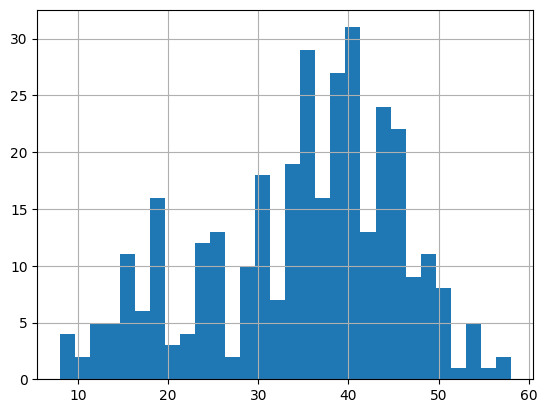

In [129]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [130]:
max_seq_len = max(seq_len)

In [131]:
max_seq_len

58

In [132]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [133]:

# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [134]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [135]:


# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [136]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,4)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
    # Pass the inputs to the model
        outputs = self.bert(sent_id, attention_mask=mask)
        cls_hs = outputs.pooler_output
        
        # Pass through fully connected layers
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
    
        return x

In [137]:
print(device)

cuda


In [138]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [139]:

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [140]:

from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[1.55555556 1.06329114 0.57931034 1.44827586]


In [141]:

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [142]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [143]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [144]:

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 1.539
Validation Loss: 1.481

 Epoch 2 / 10

Evaluating...

Training Loss: 1.422
Validation Loss: 1.398

 Epoch 3 / 10

Evaluating...

Training Loss: 1.375
Validation Loss: 1.386

 Epoch 4 / 10

Evaluating...

Training Loss: 1.351
Validation Loss: 1.339

 Epoch 5 / 10

Evaluating...

Training Loss: 1.408
Validation Loss: 1.350

 Epoch 6 / 10

Evaluating...

Training Loss: 1.358
Validation Loss: 1.331

 Epoch 7 / 10

Evaluating...

Training Loss: 1.362
Validation Loss: 1.406

 Epoch 8 / 10

Evaluating...

Training Loss: 1.368
Validation Loss: 1.331

 Epoch 9 / 10

Evaluating...

Training Loss: 1.364
Validation Loss: 1.328

 Epoch 10 / 10

Evaluating...

Training Loss: 1.313
Validation Loss: 1.333


In [145]:


# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
     

# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.25      0.18      0.21        17
           2       0.43      0.48      0.45        31
           3       0.29      0.58      0.39        12

    accuracy                           0.35        72
   macro avg       0.24      0.31      0.26        72
weighted avg       0.29      0.35      0.31        72



# ChatGPT

In [175]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts.iloc[index]  # Using .iloc for safe indexing
        label = self.labels.iloc[index]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


# Define Model
class BERTClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.fc(outputs.pooler_output)
        return logits

# Prepare Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize Model and Parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTClassifier(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training Loop
def train_model(epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Evaluation
def evaluate_model():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Run Training and Evaluation
train_model(25)
evaluate_model()


Epoch 1, Loss: 1.3140062938133876
Epoch 2, Loss: 1.1816155711809795
Epoch 3, Loss: 1.0384876082340877
Epoch 4, Loss: 0.8366707886258761
Epoch 5, Loss: 0.6099092699587345
Epoch 6, Loss: 0.43189746762315434
Epoch 7, Loss: 0.2712103072553873
Epoch 8, Loss: 0.18898326034347215
Epoch 9, Loss: 0.13201374933123589
Epoch 10, Loss: 0.10498055210337043
Epoch 11, Loss: 0.07157522859051824
Epoch 12, Loss: 0.07899878430180252
Epoch 13, Loss: 0.07652535941451788
Epoch 14, Loss: 0.06045805375712613
Epoch 15, Loss: 0.045535398880019784
Epoch 16, Loss: 0.051548777458568416
Epoch 17, Loss: 0.04173976784416785
Epoch 18, Loss: 0.03896977573943635
Epoch 19, Loss: 0.031640154348375894
Epoch 20, Loss: 0.029277472135921318
Test Accuracy: 46.88%


In [176]:
import os

def save_model(model, path='/kaggle/working/model_state_dict.pt'):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Model state dict saved to {path}")


In [177]:
save_model(model)

Model state dict saved to /kaggle/working/model_state_dict.pt


In [178]:
def save_tokenizer(tokenizer, path='/kaggle/working/tokenizer'):
    os.makedirs(path, exist_ok=True)
    tokenizer.save_pretrained(path)
    print(f"Tokenizer saved to {path}")


In [179]:
save_tokenizer(tokenizer)

Tokenizer saved to /kaggle/working/tokenizer


In [180]:
import numpy as np

def generate_embeddings(texts, tokenizer, model, batch_size=16, max_len=512):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            
            outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)

            # If pooler_output is available, use it; otherwise, use mean of last hidden state
            if hasattr(outputs, 'pooler_output'):
                batch_embeddings = outputs.pooler_output.cpu().numpy()
            else:
                batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

            embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)


In [181]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming X_train, X_test, y_train, y_test are available
X_train_embeddings = generate_embeddings(X_train.tolist(), tokenizer, model)
X_test_embeddings = generate_embeddings(X_test.tolist(), tokenizer, model)

# Train the SVM
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_embeddings, y_train)

# Predict and Evaluate
y_pred = svm_classifier.predict(X_test_embeddings)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy with SVM: {accuracy * 100:.2f}%")


Test Accuracy with SVM: 48.96%


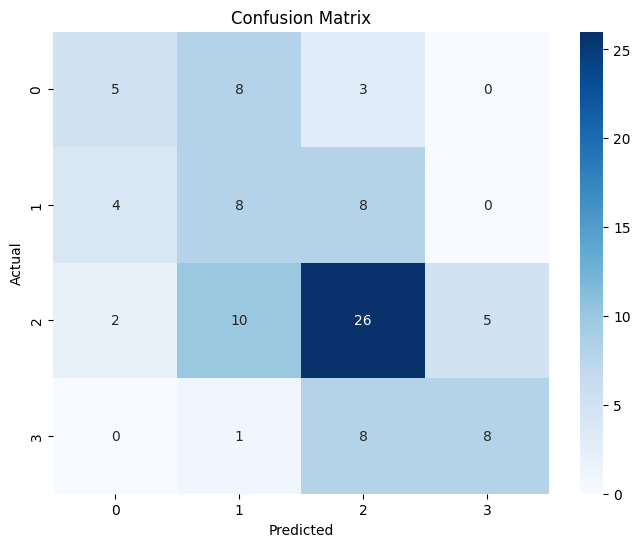

Classification Report:

              precision    recall  f1-score   support

           0       0.45      0.31      0.37        16
           1       0.30      0.40      0.34        20
           2       0.58      0.60      0.59        43
           3       0.62      0.47      0.53        17

    accuracy                           0.49        96
   macro avg       0.49      0.45      0.46        96
weighted avg       0.51      0.49      0.49        96

AUC-ROC is not applicable for multi-class classification.


In [182]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Predict using SVM
y_pred = svm_classifier.predict(X_test_embeddings)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# AUC-ROC Score
if len(set(y_test)) <= 2:
    auc_score = roc_auc_score(y_test, svm_classifier.decision_function(X_test_embeddings))
    print(f"AUC-ROC Score: {auc_score:.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, svm_classifier.decision_function(X_test_embeddings))
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
else:
    print("AUC-ROC is not applicable for multi-class classification.")
